# DS4H - P2 Exploratory Data Analysis

CS 189: Data Science For Health  
Dartmouth College  
Spring 2022  

Franklin, Ke, Spencer

To run this notebook, place the data files into a directory called 'data' that sits at the same location as this jupyter notebook. 

Physical Activity Data Source: [CDC National Center for Health Statistics](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Examination&CycleBeginYear=2013)

- [Supplimental Information on this data set](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/PAXDAY_H.htm)

Sleep Data Source: [CDC National Center for Health Statitics](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2013)

- [Supplimental Information on this data set](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/SLQ_H.htm)

# Imports

In [1]:
# Note: 
# If the theme of jupyter lab is in "Dark Mode" you won't be able to see the axis labels
# TO CHANGE THEME --> Settings --> Theme --> JupyterLab (Light/Dark)

from pathlib import Path 
from typing import Dict
import os
import random

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import scipy

import pylab as pl
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
from matplotlib_venn import venn2
plt.style.use("fivethirtyeight")
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import seaborn as sns

# Load the data using pandas

In [2]:
p: str = os.path.abspath('')
base_path: str = p[:-10] + '/data/'
print(f'Data files should be in the following directory: {base_path}')

Data files should be in the following directory: /Users/spencerbertsch/Desktop/dev/DS4H/data/


#### Load the physical activity data

In [3]:
df_active_path: str = base_path + 'PAXDAY_H.XPT'
df_active: pd.DataFrame = pd.read_sas(df_active_path)
df_active.head(5)

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD
0,73557.0,b'1',b'3',5.397605e-79,b'16:30:00',450.0,915200.0,450.0,4576.422,2.370000e+02,2.200000e+01,174.0,17.0,1.470493e+05,5.397605e-79
1,73557.0,b'2',b'4',2.160000e+06,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,7.440000e+02,1.130000e+02,546.0,37.0,1.733408e+05,5.397605e-79
2,73557.0,b'3',b'5',9.072000e+06,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,1.470000e+02,5.397605e-79,1287.0,6.0,8.340733e+04,5.397605e-79
3,73557.0,b'4',b'6',1.598400e+07,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,5.397605e-79,5.397605e-79,1439.0,1.0,5.397605e-79,5.397605e-79
4,73557.0,b'5',b'7',2.289600e+07,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,5.040000e+02,9.800000e+01,822.0,16.0,3.864985e+04,5.397605e-79


#### Load the sleep data

In [4]:
df_sleep_path: str = base_path + 'SLQ_H.XPT'
df_sleep: pd.DataFrame = pd.read_sas(df_sleep_path)
df_sleep.head(5)

,SEQN,SLD010H,SLQ050,SLQ060
0,73557.0,7.0,1.0,2.0
1,73558.0,9.0,2.0,2.0
2,73559.0,8.0,2.0,2.0
3,73561.0,9.0,2.0,2.0
4,73562.0,5.0,2.0,1.0


We know from [this source](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/SLQ_H.htm) that if the sleep hours feature is over 12, then the person chose not to respond to the survey. Similarly, we can remove the bad samples from the other sleep survey features as well.

In [5]:
df_sleep = df_sleep[df_sleep['SLD010H'] <= 12]
df_sleep = df_sleep[df_sleep['SLQ050'] <= 2]
df_sleep = df_sleep[df_sleep['SLQ060'] <= 2]

# Initial Processing and Data Observation

We can immediately see some light processing that we need to apply to use this data including the fact that the values in the physical activity data can be as small as 5.397605e-79, meaning that we need to round these values to some reasonable digit before continuing. 

In [6]:
df_active = round(df_active, 6)
df_active.head(5)

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0


# Initial Observations

The first step in EDA is to simply read all the documentation and actually understand the data set. Here we have physical activity data that was collected over time for a group of patients, and sleep data that was collected once for each patient via a survey. After joining these two data souurces together, we will have a data set with the following structure depending on the frequency of the physical activity data:



<img src="diagram.png" alt="figure" width="1000"/>

### Add nice colors

This is a list of gradients that makes for nice plots

In [7]:
hex_colors: list = [
    # blue 
    '#42A5F5', '#2196F3', '#1E88E5', '#1976D2', '#1565C0', 
    # light purple 
    '#7E57C2', '#673AB7', '#5E35B1', '#512DA8', '#4527A0', 
    # dark purple 
    '#AB47BC', '#9C27B0', '#8E24AA', '#7B1FA2', '#6A1B9A'
]

### How many of the patients belong to both of the data sets? 

We can answer this question by creating a venn diagram showing the number of patients that belong to each of the sets. 

In [8]:
physical_activity_patient_ids: set = set(df_active['SEQN'])

In [9]:
sleep_patient_ids: set = set(df_sleep['SEQN'])

In [10]:
def create_venn_2_sets(set1: set, set2: set, set1_name: str, set2_name: str):
    """
    This function can be used to create a venndiagram using two distinct sets of values. This function can be extended easily using the 'venn3' 
    library built using Matplotlib so that venn diagrams of 3 sets can be generated. 
    """
    figure(figsize=(6, 6), dpi=80)
    venn2([set1, set2], 
          (set1_name, set2_name), 
          set_colors=('purple', 'skyblue'), 
          alpha = 0.7)
    plt.show()

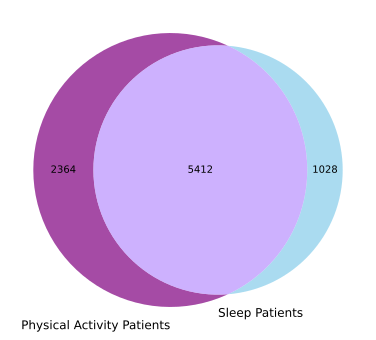

In [11]:
create_venn_2_sets(set1=physical_activity_patient_ids, set2=sleep_patient_ids, set1_name='Physical Activity Patients', set2_name='Sleep Patients')

This venn diagram shows us the set intersection betwen the patients included in each of the data sets that we're going to use. Our goal here is to combine the physical activity data and teh sleep data together, but we can only perform the join on **patient_id**. This plot shows us that even though we are losing 2,344 physical activity patients who don't have sleep data and 1,032 sleep patents who don't have physical activity data, we still have 5,432 patients to use in our analysis. 

## Join the physical activity and sleep data together 

At this point we can now perform an inner join to merge these two data sets together

In [12]:
df_joined = df_active.merge(df_sleep, left_on='SEQN', right_on='SEQN')
df_joined.head()

,SEQN,PAXDAYD,PAXDAYWD,PAXSSNDP,PAXMSTD,PAXTMD,PAXAISMD,PAXVMD,PAXMTSD,PAXWWMD,PAXSWMD,PAXNWMD,PAXUMD,PAXLXSD,PAXQFD,SLD010H,SLQ050,SLQ060
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0,7.0,1.0,2.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0,7.0,1.0,2.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0,7.0,1.0,2.0
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0,7.0,1.0,2.0
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0,7.0,1.0,2.0


### Use a dictionary to rename all the columns

In [13]:
renamer: dict = {'SEQN': 'patient_id', 
                 'PAXDAYD': 'day',
                 'PAXDAYWD': 'day_of_week',
                 'PAXSSNDP': 'start_num',
                 'PAXMSTD': 'start_time',
                 'PAXTMD': 'total_collection_time',
                 'PAXAISMD': 'sleep_mode_measurements',
                 'PAXVMD': 'valid_data_minutes',
                 'PAXMTSD': '3d_acceleration',
                 'PAXWWMD': 'minutes_awake',
                 'PAXSWMD': 'minutes_asleep',
                 'PAXNWMD': 'minutes_not_worn',
                 'PAXUMD': 'minutes_no_data',
                 'PAXLXSD': 'ambient_light_measure',
                 'PAXQFD': 'data_quality_flag',
                 'SLD010H': 'sleep_hours', 
                 'SLQ050':'trouble_sleeping', 
                 'SLQ060':'sleep_disorder'}

In [14]:
df_joined = df_joined.rename(columns=renamer)
df_joined.head()

,patient_id,day,day_of_week,start_num,start_time,total_collection_time,sleep_mode_measurements,valid_data_minutes,3d_acceleration,minutes_awake,minutes_asleep,minutes_not_worn,minutes_no_data,ambient_light_measure,data_quality_flag,sleep_hours,trouble_sleeping,sleep_disorder
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0,7.0,1.0,2.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0,7.0,1.0,2.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0,7.0,1.0,2.0
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0,7.0,1.0,2.0
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0,7.0,1.0,2.0


In [15]:
cols = ['patient_id',  'day', 'day_of_week', 'start_num', 'start_time', 'total_collection_time', 'sleep_mode_measurements', \
        'valid_data_minutes', '3d_acceleration', 'minutes_awake', 'minutes_asleep', 'minutes_not_worn', 'minutes_no_data', \
        'ambient_light_measure', 'data_quality_flag', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']

numeric_cols = ['patient_id', 'start_num', 'total_collection_time', 'sleep_mode_measurements', \
                'valid_data_minutes', '3d_acceleration', 'minutes_awake', 'minutes_asleep', 'minutes_not_worn', 'minutes_no_data', \
                'ambient_light_measure', 'data_quality_flag', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']

### How are the physical activity measurements correlated to the sleep values across patients? 

We can answer this question by grouping each cluster of physical activity values to get the mean value for each patient, then generating a correlation matrix to see how each fearure is correlated with the sleep featuers. 

In [16]:
df_grouped: pd.DataFrame = df_joined.groupby('patient_id').mean()
df_grouped['patient_id'] = df_grouped.index
df_grouped.head()

,start_num,total_collection_time,sleep_mode_measurements,valid_data_minutes,3d_acceleration,minutes_awake,minutes_asleep,minutes_not_worn,minutes_no_data,ambient_light_measure,data_quality_flag,sleep_hours,trouble_sleeping,sleep_disorder,patient_id
patient_id,,,,,,,,,,,,,,,
73557.0,23424000.0,1281.0,3.997156e+06,1281.000000,6369.495333,350.777778,82.777778,833.555556,13.888889,108972.836667,0.000000,7.0,1.0,2.0,73557.0
73558.0,22144000.0,1281.0,2.742481e+06,1280.666667,8307.157778,678.555556,383.333333,158.000000,60.777778,64439.798889,0.333333,9.0,2.0,2.0,73558.0
73559.0,24448000.0,1281.0,3.228436e+06,1281.000000,8005.963333,658.888889,511.111111,43.555556,67.444444,279876.924444,0.000000,8.0,2.0,2.0,73559.0
73561.0,24448000.0,1281.0,2.305937e+06,1280.666667,6470.660889,680.111111,501.000000,25.777778,73.777778,65044.487778,0.333333,9.0,2.0,2.0,73561.0
73562.0,23168000.0,1281.0,2.637164e+06,1279.666667,14613.943222,836.333333,385.111111,0.000000,58.222222,20804.137778,1.333333,5.0,2.0,1.0,73562.0


Now that we have the grouped dataframe we can generate the correlation matrix and use a heatmap to visualize it. 

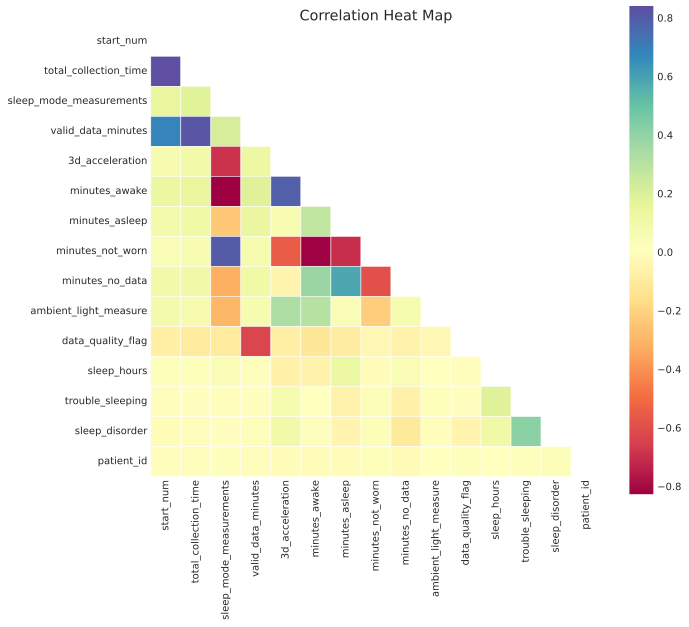

In [17]:
corr = df_grouped.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 9))
    ax = sns.heatmap(corr, mask=mask, square=True, cmap="Spectral", linewidths=0.5).set_title('Correlation Heat Map')

Some of the physical activity data are highly coelated - either positively or negatively - but there isn't a strong positive or negative correlation between any of the physical activity features and the sleep features. 

We know that each patient has a week's worth of time series physical activity data, so we can also plot a few of the samples to see what they look like.

In [18]:
single_patient_df: pd.DataFrame = df_joined[df_joined['patient_id'] == 73557.0]
single_patient_df.head()

,patient_id,day,day_of_week,start_num,start_time,total_collection_time,sleep_mode_measurements,valid_data_minutes,3d_acceleration,minutes_awake,minutes_asleep,minutes_not_worn,minutes_no_data,ambient_light_measure,data_quality_flag,sleep_hours,trouble_sleeping,sleep_disorder
0,73557.0,b'1',b'3',0.0,b'16:30:00',450.0,915200.0,450.0,4576.422,237.0,22.0,174.0,17.0,147049.33,0.0,7.0,1.0,2.0
1,73557.0,b'2',b'4',2160000.0,b' 0:00:00',1440.0,2989920.0,1440.0,12222.152,744.0,113.0,546.0,37.0,173340.75,0.0,7.0,1.0,2.0
2,73557.0,b'3',b'5',9072000.0,b' 0:00:00',1440.0,3307840.0,1440.0,3158.922,147.0,0.0,1287.0,6.0,83407.33,0.0,7.0,1.0,2.0
3,73557.0,b'4',b'6',15984000.0,b' 0:00:00',1440.0,6860400.0,1440.0,23.641,0.0,0.0,1439.0,1.0,0.00,0.0,7.0,1.0,2.0
4,73557.0,b'5',b'7',22896000.0,b' 0:00:00',1440.0,3968640.0,1440.0,8879.010,504.0,98.0,822.0,16.0,38649.85,0.0,7.0,1.0,2.0


In [19]:
def plot_physical_activity_for_single_patient(signals_to_plot: list):
    fig, axs = plt.subplots(len(signals_to_plot), figsize=(12, 15))
    # fig.suptitle('Physical Activity Signals for a Single Patient', fontsize=12)
    
    for i, feature in enumerate(signals_to_plot):
        axs[i].plot(single_patient_df.index, single_patient_df[signals_to_plot[i]], color=random.choice(hex_colors))

    for i, ax in enumerate(axs.flat):
        ax.set(ylabel=signals_to_plot[i])

    ax.set(xlabel='Time (Day of the week)')

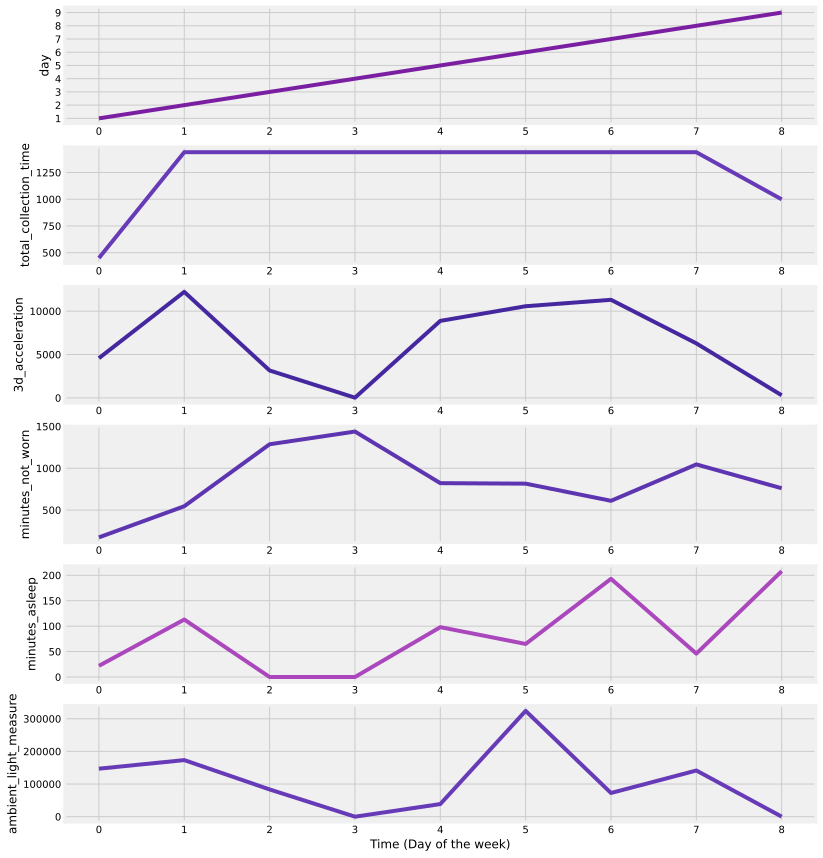

In [20]:
plot_physical_activity_for_single_patient(signals_to_plot = ['day', 'total_collection_time', '3d_acceleration', \
                                                             'minutes_not_worn', 'minutes_asleep', 'ambient_light_measure'])

We can see here that each time series presents a unique signal, giving us a rich data environment to work with for applications such as forecasting or time series classification.

We can also look at the distribution of each of the features individually - in order to do this we use a histogram:

In [21]:
physical_activity_features = ['patient_id',  'day', 'day_of_week', 'start_num', 'start_time', 'total_collection_time', \
                              'sleep_mode_measurements', 'valid_data_minutes', '3d_acceleration', 'minutes_awake', 'minutes_asleep', \
                              'minutes_not_worn', 'minutes_no_data', 'ambient_light_measure', 'data_quality_flag']

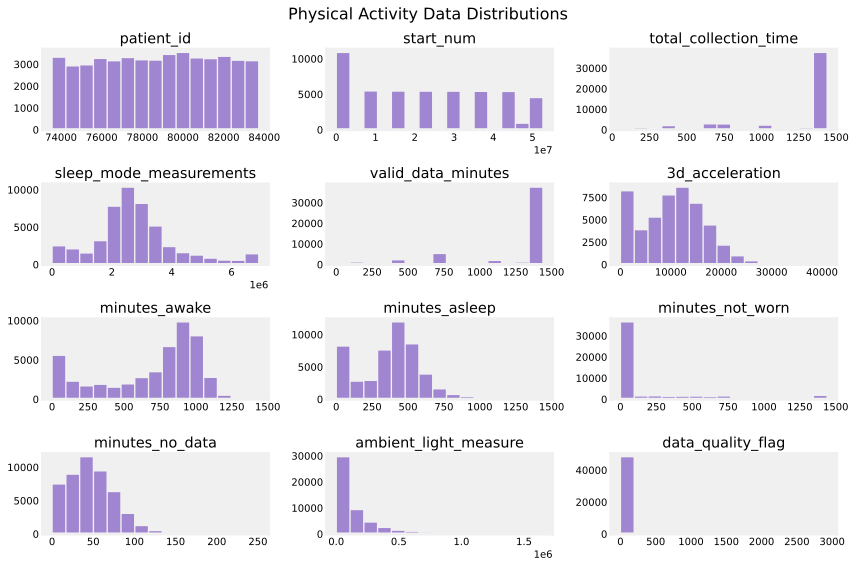

In [22]:
df_joined[physical_activity_features].hist(
    bins=15,
    figsize=(12, 8),
    grid = False,
    rwidth = 0.9,
    alpha=0.7,
    color=random.choice(hex_colors)
)
pl.suptitle("Physical Activity Data Distributions", fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
sleep_features = ['patient_id',  'sleep_hours', 'trouble_sleeping', 'sleep_disorder']

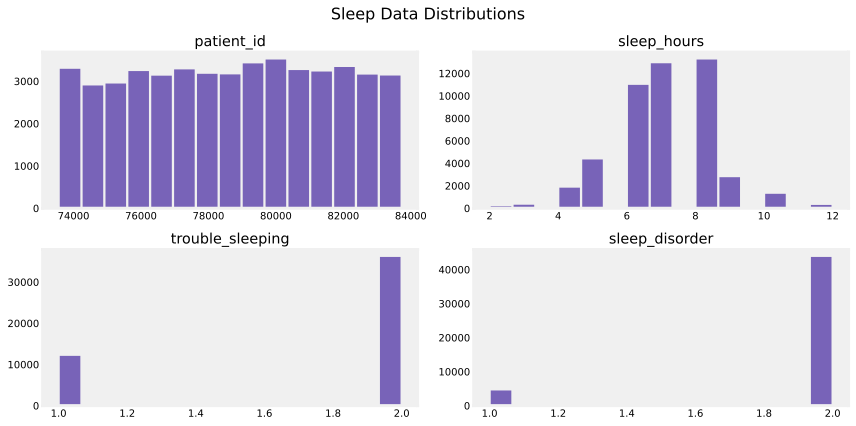

In [24]:
df_joined[sleep_features].hist(
    bins=15,
    figsize=(12, 6),
    grid = False,
    rwidth = 0.9,
    alpha=0.7,
    color=random.choice(hex_colors)
)
pl.suptitle("Sleep Data Distributions", fontsize=16)
plt.tight_layout()
plt.show()

As expected, we see a uniform distribution for the patient id. We can see a normal distribution for the number of hours that participants slept, and we can see that most of the participants not not report trouble sleeping or having a sleep disorder. 

We can also use the pandas builtin functions for plotting - for example we can also understand the mean, Q1, Q3, Min, Max, and outliers using a boxplot: 

<AxesSubplot:>

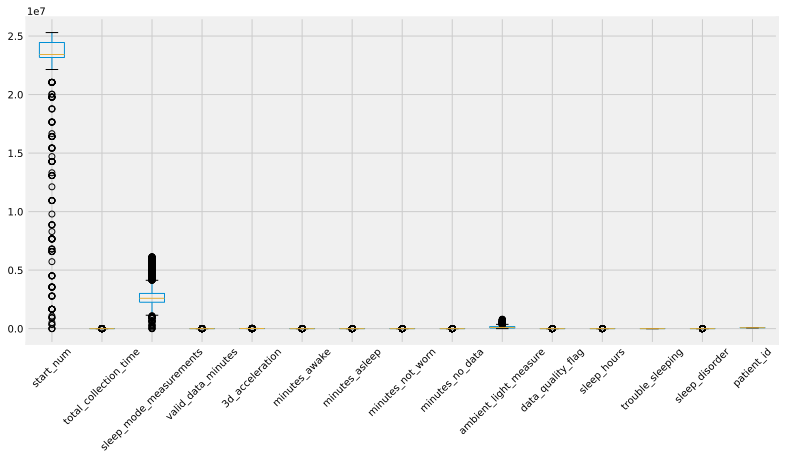

In [25]:
fig, axs = plt.subplots(figsize=(12, 6))
df_grouped.boxplot(rot=45)

### Scale the data for boxplot

We can see that the values of some features range up to $2.5 \cdot 10^7$, so we can use a min-max scalar to produce scaled data that we can then visualize using the same type of boxplot:

<AxesSubplot:>

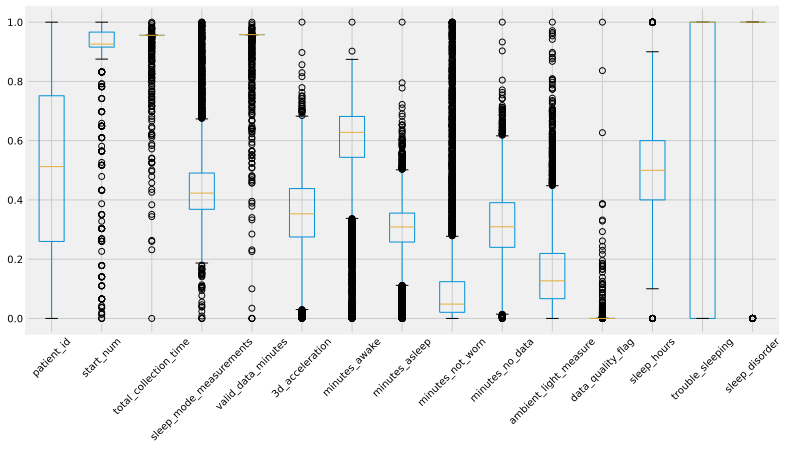

In [26]:
df_joined_numeric = df_grouped[numeric_cols]
# define min max scaler
scaler = MinMaxScaler()
# transform data
df_scaled = scaler.fit_transform(df_joined_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=numeric_cols)
df_scaled.head()

fig, axs = plt.subplots(figsize=(12, 6))
df_scaled.boxplot(rot=45)

We can see here that the sleep data values are all relatively small and show little variance compared with the physical activity data. This is expected because the sleep data is the result of surveys while the physical activity data was collected from sensors. 

# A deeper look at 3D acceleration 

We can see that 3D acceleration measures movement, which is a proxy for physical activity. Joining this signal with sleep data allows us to investigate a few interesting questions: 

1. Does more exercise mean more sleep?
2. Does more exercise mean fewer reported sleep disorders? 

To answer these questions visually, we want to understand how these two variales move together. To do this, we can group the 3d_acceleration data by patient_id and take the mean or the sum, then create a scatter plot of those values against various sleep values. We can look at the $R^2$ value of a line of best fit to see if there is any significant correlation between more physical activity and more sleep, or fewer reported sleep disorders. 

In [27]:
df = df_joined[['patient_id', '3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']]
df_grouped = df.groupby(['patient_id'])[['3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']].mean()
df_grouped = df_grouped.reset_index()
df_grouped.head()

,patient_id,3d_acceleration,sleep_hours,trouble_sleeping,sleep_disorder
0,73557.0,6369.495333,7.0,1.0,2.0
1,73558.0,8307.157778,9.0,2.0,2.0
2,73559.0,8005.963333,8.0,2.0,2.0
3,73561.0,6470.660889,9.0,2.0,2.0
4,73562.0,14613.943222,5.0,2.0,1.0


In [28]:
def plot_acceleration_vs_sleep_hours(df: pd.DataFrame):
    fig, axs = plt.subplots(figsize=(12, 8))
    
    df = df[['patient_id', '3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']]
    df_grouped = df.groupby(['patient_id'])[['3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']].mean()
    df_grouped = df_grouped.reset_index()
    
    x = df_grouped['3d_acceleration']
    y = df_grouped['sleep_hours']
    
    #find line of best fit
    a, b = np.polyfit(x, y, 1)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    r_squared = r_value**2

    plt.scatter(x, y, c=random.choice(hex_colors), alpha=0.5)
    
    #add line of best fit to plot
    plt.plot(x, a*x+b, color='red', linewidth=1.5)  
    
    # annotate the plot with the information we have
    plt.text(21500, 11, f'Best Fit: y = {round(b, 3)} + {round(a, 3)}x', size=12)
    plt.text(21500, 10.6, f'R Squared: {round(r_squared, 4)}', size=12)
    plt.text(21500, 10.2, f'P Value: {round(p_value, 10)}', size=12)
    
    plt.xlabel("3D_Acceleration")
    plt.ylabel("Sleep Hours")
    plt.title(f'3D_Acceleration (Activity) vs. Reported Sleep Hours', fontsize=16)
    plt.show()

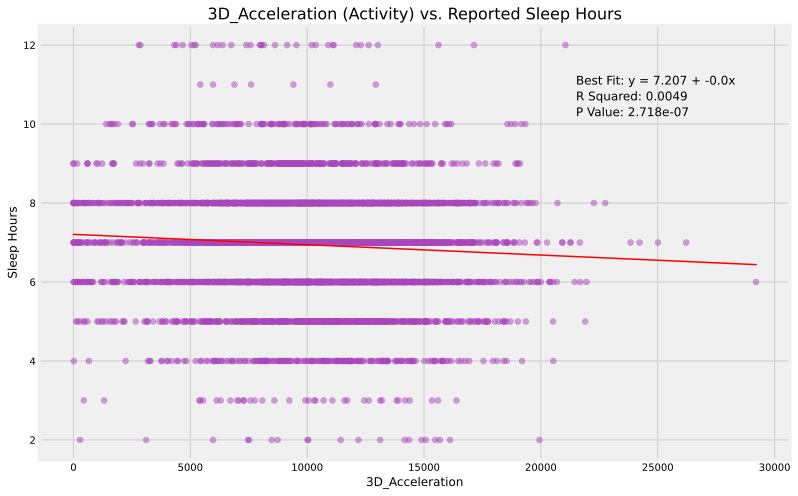

In [29]:
plot_acceleration_vs_sleep_hours(df=df_joined)

So we can see here that there is no relationship between the amount of x, y, z acceleration on the wrist and the number of sleep hours that someone reports. Now we can investigate whether or not 'activity' impacts the prevelance of a sleep disorder:

In [30]:
df_grouped[df_grouped['trouble_sleeping'] == 1][['3d_acceleration', 'trouble_sleeping']].head()

,3d_acceleration,trouble_sleeping
0,6369.495333,1.0
6,16090.007444,1.0
9,5104.514444,1.0
24,8555.576667,1.0
28,11424.722333,1.0


In [31]:
def plot_acceleration_vs_sleep_disorder(df: pd.DataFrame, sleep_metric: str):
    
    df = df[['patient_id', '3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']]
    df_grouped = df.groupby(['patient_id'])[['3d_acceleration', 'sleep_hours',  'trouble_sleeping',  'sleep_disorder']].mean()
    df_grouped = df_grouped.reset_index()
    
    # generate the columns we need
    df_grouped['yes'] = 'yes'
    df_grouped['no'] = 'no'
    df_grouped['trouble_sleeping'] = np.where(df_grouped['trouble_sleeping'] == 1, df_grouped['yes'], df_grouped['no'])
    df_grouped['sleep_disorder'] = np.where(df_grouped['sleep_disorder'] == 1, df_grouped['yes'], df_grouped['no'])
    
    df1_reduced = df_grouped[['3d_acceleration', 'trouble_sleeping']]
    df2_reduced = df_grouped[['3d_acceleration', 'sleep_disorder']]
    
    f, axes = plt.subplots(1, 2, figsize = (10,8))
    sns.boxplot(x='trouble_sleeping',y='3d_acceleration', hue='trouble_sleeping',  data=df1_reduced, ax=axes[0])
    sns.boxplot(x='sleep_disorder',y='3d_acceleration', hue='sleep_disorder',  data=df2_reduced, ax=axes[1])
    plt.suptitle('\n Activity and Reported Sleep Disorders',fontsize=16)
    

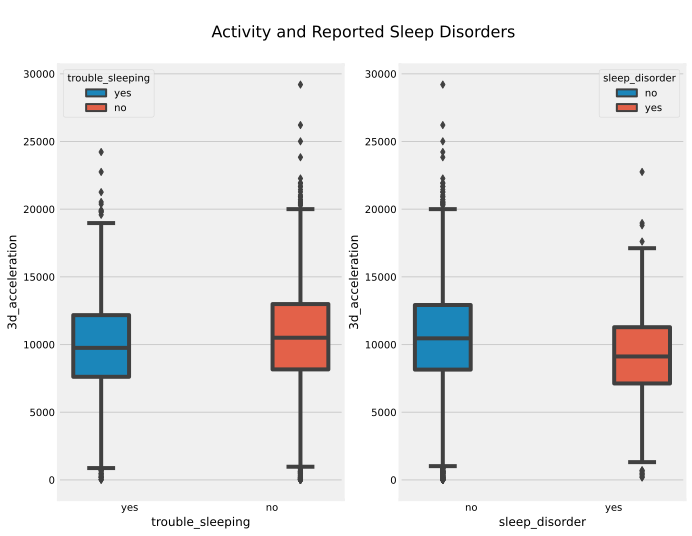

In [32]:
plot_acceleration_vs_sleep_disorder(df=df_joined, sleep_metric='trouble_sleeping')

So an interesting result - it looks like people who get a little bit more physical activity are also the ones who are reporting more sleep disorders and trouble sleeping. It will take some more analysis to see whether or not this relationship is significant or causal, but it's interesting to simply separate the groups and observe their differences using a subplotted box plot like this. 